In [1]:
%matplotlib inline

import os
import pandas as pd
import sys
import logging
import random
import time
## for viewing pdfs
from wand.image import Image as WImage

## modules
sys.path.insert(0, './_modules')
from scanner_module import scanner, decode
from orchestra_module import get_table
import matplotlib.pyplot as plt
from regex_module import FindEmail, FindNumbersBraket, FindLawsuit

plt.style.use('ggplot')

/home/dev/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Credentials ok!


In [2]:
cwd = os.getcwd()
print(cwd)

## specifying the path to database:
attachments_path = os.path.join(cwd, '_attachments')
print(attachments_path)

## specifying the path to collect control:
control_path = os.path.join(cwd, '_collect_control')
print(control_path)

/home/dev/sigo
/home/dev/sigo/_attachments
/home/dev/sigo/_collect_control


In [3]:
## att file:'att_data.csv'
df = pd.read_csv(os.path.join(control_path, 'att_data.csv'), sep = '\t', encoding = 'utf-8')


In [4]:
df

,mail_id,doc_name,doc_link
0,16e7f52e8897940d,316:2019.pdf,/home/dev/sigo/_attachments/16e7f52e8897940d/3...
1,16efbfe76f3c98a7,02367-2019_Redacted.pdf,/home/dev/sigo/_attachments/16efbfe76f3c98a7/0...
2,16c73a4539a90832,Court Order #6429.pdf,/home/dev/sigo/_attachments/16c73a4539a90832/C...
3,16ea8eba4927ca92,592-2019_Redacted.pdf,/home/dev/sigo/_attachments/16ea8eba4927ca92/5...
4,16fe846f16206c67,01 2020_Redacted.pdf,/home/dev/sigo/_attachments/16fe846f16206c67/0...
...,...,...,...
25637,1729624a76f07663,3714375.pdf,/home/dev/sigo/_attachments/1729624a76f07663/3...
25638,172963edb799c9bf,Planilha de Producao (3724158) - Standard.pdf,/home/dev/sigo/_attachments/172963edb799c9bf/P...
25639,172963f79924dcfc,Planilha de Producao (3767731) - Standard.pdf,/home/dev/sigo/_attachments/172963f79924dcfc/P...
25640,172963f79924dcfc,Planilha de Producao (3736791) - Product Date ...,/home/dev/sigo/_attachments/172963f79924dcfc/P...


In [5]:
df_group = df.groupby('mail_id')['doc_link'].apply(list).to_frame().reset_index()
df_group.columns = ['mail_id', 'doc_link_list']

In [6]:
## getting the full mail data table
df_full = get_table('screening_table', option = 'full')

## converting to time object
df_full['mail_hms_received'] = pd.to_datetime(df_full['mail_hms_received']).dt.time

## converting to datetime object
df_full['mail_date_received'] = pd.to_datetime(df_full['mail_date_received'])


## unifying date and time columns into one single datetime object:
df_full['mail_datetime_received'] = pd.to_datetime(df_full['mail_date_received'].apply(str) +\
                                              ' ' + df_full['mail_hms_received'].apply(str))

df_full['mail_datetime_received'] = pd.to_datetime(df_full['mail_datetime_received'])

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  """


In [16]:
df_full = df_full.merge(df_group, how = 'left', on = 'mail_id')

In [17]:
df_full.sample(10)

,main_id,mail_id,thread_id,mail_date_received,mail_hms_received,mail_subject,mail_from,mail_body,mail_body_snippet,has_attachment,attachment_folder_link,case_id,external_ref_number,date_created,date_updated,mail_datetime_received,doc_link_list
11362,11363,16da74c8defbc603,16d96e110e07c187,2019-10-07,17:37:51,RES: [0-0761000028314] Encaminha Ordem Judicial,rafael.kohl@carinaquito.com,"b'Hi all,\r\n\r\n \r\n\r\nThis is related to t...","Hi all, This is related to the case [8-1142000...",0,None,0-0761000028314,,2020-03-03 22:50:14,2020-03-03 22:50:14,2019-10-07 17:37:51,NaN
16053,16054,171aeb084693b86d,171a437a587471ec,2020-04-25,00:15:35,Re: [4-2496000029924] - c 2020/04/24 - April 2...,lis-latam@google.com,"b'\r\n\r\nHi,\r\n\r\nPlease find attached the ...","Hi, Please find attached the .pdf file with ou...",1,None,4-2496000029924,0007294-48.2020.8.16.0013,2020-04-25 12:58:05,2020-04-25 12:58:05,2020-04-25 00:15:35,[/home/dev/sigo/_attachments/171aeb084693b86d/...
16880,16881,171cd5557204135c,171cd5557204135c,2020-04-30,23:03:51,"[2-5899000030472] - c 2020/05/04 - May 4th, 20...",rafael.kohl@carinaquito.com,b'*Last Name: *Vara \xc3\x9anica de Independ\x...,Last Name: Vara Única de Independência - CE Co...,1,None,2-5899000030472,10048-93.2020.8.06.0092,2020-05-23 17:48:38,2020-05-23 17:48:38,2020-04-30 23:03:51,[/home/dev/sigo/_attachments/171cd5557204135c/...
10126,10127,16d159a3064a49cb,16d159a3064a49cb,2019-09-09,10:38:07,[5-0530000027705] BR Data Request 907-00076/2019,lis-latam@google.com,"b'\r\n\r\nDate received via LERS: September 7,...","Date received via LERS: September 7, 2019 LERS...",1,None,5-0530000027705,,2020-03-03 22:14:20,2020-03-03 22:14:20,2019-09-09 10:38:07,[/home/dev/sigo/_attachments/16d159a3064a49cb/...
10433,10434,16c8b9f28d67f0d1,16c8b9f28d67f0d1,2019-08-13,15:35:57,FWD: [6-0822000027592] BR Data Request 0000718...,lis-latam@google.com,"b'\r\n\r\nDate received via LERS: August 13, 2...","Date received via LERS: August 13, 2019 LERS r...",1,None,6-0822000027592,,2020-03-03 22:23:17,2020-03-03 22:23:17,2019-08-13 15:35:57,[/home/dev/sigo/_attachments/16c8b9f28d67f0d1/...
9686,9687,16eec523bcbe4a73,16eec523bcbe4a73,2019-12-09,20:20:36,[7-4579000028978] - c 2019/12/10 - FINES - Dec...,rafael.kohl@carinaquito.com,b'*Last Name: *2\xc2\xaa Vara Criminal de Rio ...,Last Name: 2ª Vara Criminal de Rio Branco/AC C...,1,None,7-4579000028978,0012167-81.2019.8.01.0001,2020-03-03 22:00:32,2020-03-03 22:00:32,2019-12-09 20:20:36,[/home/dev/sigo/_attachments/16eec523bcbe4a73/...
19030,19031,17294dc77a7eadc0,17281e51c758ed9c,2020-06-08,16:56:15,Re: [8-8889000030501] - LEGAL ISSUE - c 2020/0...,lis-latam@google.com,"b'\r\n\r\nHi all,\r\n\r\nAttached the planilha...","Hi all, Attached the planilha for this case. P...",1,None,8-8889000030501,5036867-91.2020.8.24.0023,2020-06-08 16:57:37,2020-06-08 16:57:37,2020-06-08 16:56:15,[/home/dev/sigo/_attachments/17294dc77a7eadc0/...
16964,16965,17232d8b01ec5d57,17232d8b01ec5d57,2020-05-20,16:09:03,[9-9478000030547] URGENT 24 HOURS - OVERDUE - ...,rafael.kohl@carinaquito.com,b'*Last Name: *4\xc2\xaa Vara Criminal de Sino...,Last Name: 4ª Vara Criminal de Sinop - MT Coun...,1,None,9-9478000030547,16848-73.2019.811.0015,2020-05-23 17:50:57,2020-05-23 17:50:57,2020-05-20 16:09:03,[/home/dev/sigo/_attachments/17232d8b01ec5d57/...
4162,4163,16efaa154a9a729f,16eb956f1e90fa54,2019-12-12,15:01:45,RES: Diligência - Vara Criminal de Inquéritos ...,denise.comim@carinaquito.com,"b""Prezado Dr. Gustavo, bom dia.\r\n\r\n\r\n\r\...","Prezado Dr. Gustavo, bom dia. Agradecemos o en...",0,None,,,2020-03-03 18:58:49,2020-03-03 18:58:49,2019-12-12 15:01:45,NaN
11097,11098,16ddc01c46dc3a6e,16ddc01c46dc3a6e,2019-10-17,23:15:46,[2-6181000027923] - c 2019/10/28 - October 28t...,helena.rossi@carinaquito.com,b'Last Name: 1\xc2\xaa Vara Criminal de Santar...,Last Name: 1ª Vara Criminal de Santarém/PA Cou...,1,None,2-6181000027923,0004880-51.2019.814.0051,2020-03-03 22:42:37,2020-03-03 22:42:37,2019-10-17 23:1

In [32]:
k = random.choice(list(df_full.index))
print(k)
print(df_full['mail_from'][k])
print(df_full['mail_subject'][k])
print('------')
print(df_full['mail_body_snippet'][k])
print('__________')
print(set(df_full['doc_link_list'][k]))
print(' ')
print(' ')


links_list = list(set(df_full['doc_link_list'][k]))
print(links_list)

9705
lis-latam@google.com
Re: [4-8575000027916] - PETITION -c 2019/10/22 - October 22nd, 2019 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX  #7174
------
Hi all, Attached the response letter for this case. Production was shared directly with LE via LERS to fcoelho@pcivil.rj.gov.br. Best, Alexa- LIS On Tue, Oct 22, 2019 at 14:13 UTC &quot;Mohamad Fares
__________
{'/home/dev/sigo/_attachments/16e1460c746c769a/2987542.pdf'}
 
 
['/home/dev/sigo/_attachments/16e1460c746c769a/2987542.pdf']


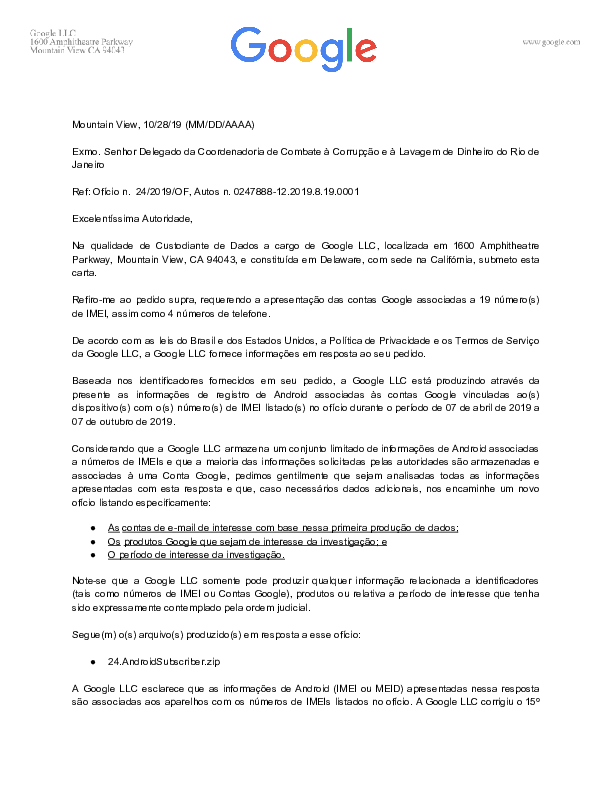

In [33]:
pdf_list = [item for item in links_list if '.pdf' in item]
if len(pdf_list) != 0:
    pdf_view = WImage(filename= pdf_list[0]) 
pdf_view

In [23]:
## Scan doc and find lawsuit:
start_time = time.time()
lawsuit_list = []
for item in links_list:
    doc_scanned = ' '.join(scanner(item))
    doc_scanned = doc_scanned.replace('\n', ' ').replace('—', '-')
    lawsuit = FindLawsuit(doc_scanned)
    lawsuit_list.append(lawsuit)
    decode_result = decode(item)
    print(decode_result)
    if lawsuit != '':
        print(lawsuit)
    else:
        print('Lawsuit not found')
print('tot time: {}'.format(time.time() - start_time))

[]
0001212-12.2019.8.08.0028
[]
0001212-12.2019.8.08.0028
tot time: 98.70278978347778


In [26]:
def AttReader(link):
    '''
    Scan the attached docs in order to find QR codes and/or lawsuit number
    '''

    doc_scanned = ' '.join(scanner(link))
    doc_scanned = doc_scanned.replace('\n', ' ').replace('—', '-')
    lawsuit = FindLawsuit(doc_scanned)
    decode_result = decode(item)

    return lawsuit, decode_result
   

In [41]:
df_test = df.sample(10)
df_test

,mail_id,doc_name,doc_link
25562,172940d59857a713,5004562-62.2020.4.03.6105_Redacted.pdf,/home/dev/sigo/_attachments/172940d59857a713/5...
23703,171f1b9a4dae117f,Court Order #8946.pdf,/home/dev/sigo/_attachments/171f1b9a4dae117f/C...
3172,16db2664cb5678c7,0222977-33.2019.2019.8.19.0001.pdf,/home/dev/sigo/_attachments/16db2664cb5678c7/0...
1585,16d22ab2866cab6f,Court Order #6766.pdf,/home/dev/sigo/_attachments/16d22ab2866cab6f/C...
15357,16ef10b2983b63bb,Protocolo Promotoria de Campo Largo 02.12.19.pdf,/home/dev/sigo/_attachments/16ef10b2983b63bb/P...
23093,171ea9e57f73ae66,591-2020_Redacted.pdf,/home/dev/sigo/_attachments/171ea9e57f73ae66/5...
14341,1705da750450d74e,004-2020.pdf,/home/dev/sigo/_attachments/1705da750450d74e/0...
15506,16fc94243d40bf67,ofício igarape.pdf,/home/dev/sigo/_attachments/16fc94243d40bf67/o...
15410,16e0466c99417c9e,2283222-80:2019_Redacted.pdf,/home/dev/sigo/_attachments/16e0466c99417c9e/2...
14035,16df9495e9f0f937,Court Order #7218.pdf,/home/dev/sigo/_attachments/16df9495e9f0f937/C...


In [43]:
df_test['external_ref_number'], df_test['QR_code'] =  zip(*df_test['doc_link'].apply(AttReader))


In [44]:
df_test

,mail_id,doc_name,doc_link,external_ref_number,QR_code
25562,172940d59857a713,5004562-62.2020.4.03.6105_Redacted.pdf,/home/dev/sigo/_attachments/172940d59857a713/5...,5004562-62.2020.4.03.6105,()
23703,171f1b9a4dae117f,Court Order #8946.pdf,/home/dev/sigo/_attachments/171f1b9a4dae117f/C...,5023275-20.2020.4.02.5101,()
3172,16db2664cb5678c7,0222977-33.2019.2019.8.19.0001.pdf,/home/dev/sigo/_attachments/16db2664cb5678c7/0...,0222977-33.2019.8.19.0001,()
1585,16d22ab2866cab6f,Court Order #6766.pdf,/home/dev/sigo/_attachments/16d22ab2866cab6f/C...,0002676-73.2019.8.16.0117,()
15357,16ef10b2983b63bb,Protocolo Promotoria de Campo Largo 02.12.19.pdf,/home/dev/sigo/_attachments/16ef10b2983b63bb/P...,0008246-22.2019.8.16.026,()
23093,171ea9e57f73ae66,591-2020_Redacted.pdf,/home/dev/sigo/_attachments/171ea9e57f73ae66/5...,0015848-67.2020.8.21.0001,()
14341,1705da750450d74e,004-2020.pdf,/home/dev/sigo/_attachments/1705da750450d74e/0...,,()
15506,16fc94243d40bf67,ofício igarape.pdf,/home/dev/sigo/_attachments/16fc94243d40bf67/o...,1.113.163-8,()
15410,16e0466c99417c9e,2283222-80:2019_Redacted.pdf,/home/dev/sigo/_attachments/16e0466c99417c9e/2...,0013824-49.2019.8.26.0361,()
14035,16df9495e9f0f937,Court Order #7218.pdf,/home/dev/sigo/_attachments/16df9495e9f0f937/C...,,()


In [24]:
## view line
df_view = df_sample.loc[k, :].to_frame().reset_index()
df_view.columns = ['data', 'value']
df_view

,data,value
0,mail_id,16c62f3566c769d2
1,doc_link_list,[/home/dev/sigo/_attachments/16c62f3566c769d2/...
2,main_id,11654
3,thread_id,16c62f3566c769d2
4,mail_date_received,2019-08-05 00:00:00
5,mail_hms_received,18:03:29
6,mail_subject,FWD: [7-0918000027140] BR Data Request 077/2018AL
7,mail_from,lis-latam@google.com
8,mail_body,b'\r\n\r\nUrgent - 5 days\r\n\r\nDate received...
9,mail_body_snippet,Urgent - 5 days Date received via LERS: Aug 05...


In [25]:
df_full.groupby('external_ref_number')['mail_id'].apply(list)

external_ref_number
                             [16e621b40e2a0718, 16c0626420c86643, 16eb93bc2...
0000006-28.2020.8.21.0072                 [170a79eb63e7f55c, 170bb4961906f77e]
0000006-60.2020.8.04.2801    [1720642dcac96a2a, 171c7e40590714dd, 172158796...
0000012-94.2020.8.21.0117    [1711c9d8961106a5, 1712d165aec03e8e, 1713d374e...
0000013-73.2020.8.22.0013    [16fd4aa2213db4d6, 16fcf7d0017aff53, 16ff2850e...
                                                   ...                        
9366-80.2019.811                          [16e1468bfa9fa0e2, 16dcc777e720da27]
9586-35.2014.4.01.3200                                      [16da74fe3f26ba86]
9586-35.2019.4.01.3200       [16dad0f4728a872e, 16e908f4d832b8dd, 16dd6d388...
97-2020.8.08.0048                                           [170f44e1923ead39]
983-83.2019.8.26.0107        [16d4a57b65eae85e, 171a2c66be2946a0, 171997ae9...
Name: mail_id, Length: 2414, dtype: object